In [1]:
# RUN ONLY IF NEEDED (on Kaggle some packages may already be installed)
!pip install -q transformers datasets evaluate tokenizers sentencepiece
!pip install -q torch torchvision  # Kaggle usually has torch
!pip install -q sentence-transformers
!pip install -q joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == 

In [4]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# show plots inline
%matplotlib inline

# paths (عدل المسارات إذا لزم)
INPUT_DIR = "/kaggle/input/twitter-entity-sentiment-analysis"
WORK_DIR = "/kaggle/working"
os.makedirs(WORK_DIR, exist_ok=True)


In [5]:
# Try common file names in the dataset
files = os.listdir(INPUT_DIR)
files


['twitter_validation.csv', 'twitter_training.csv']

In [6]:
# تحديد ملف التدريب (غير إذا كان مختلف)
train_fname = None
for f in files:
    if "train" in f.lower() or "twitter_training" in f.lower():
        train_fname = f
        break
if train_fname is None:
    # fallback: pick first csv
    for f in files:
        if f.endswith(".csv"):
            train_fname = f; break

print("Using file:", train_fname)

# قراءة مرنة: إن الملف بلا header نمرر names
df = pd.read_csv(os.path.join(INPUT_DIR, train_fname), header=None)
# إذا ظهر إن الصف الأول عبارة عن رؤوس، عدل header
# نتحقق من عدد الأعمدة لنعطي أسماء مناسبة
print("shape:", df.shape)
df.head(5)


Using file: twitter_training.csv
shape: (74682, 4)


,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
# إن الملف بلا header، نعيّن أسماء الأعمدة
if df.shape[1] == 4:
    df.columns = ["tweet_id", "entity", "sentiment", "text"]
elif df.shape[1] == 5:
    # لو فيه عمود label إضافي
    df.columns = ["tweet_id", "entity", "sentiment", "text", "label"]
else:
    # محاولة ثانية بقراءة مع header=0
    df = pd.read_csv(os.path.join(INPUT_DIR, train_fname), header=0)
    print("Re-read with header, shape:", df.shape)
    print(df.columns.tolist())

df.columns = df.columns.str.strip()
print(df.columns.tolist())
df.head(5)


['tweet_id', 'entity', 'sentiment', 'text']


,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
import html
from tqdm.auto import tqdm

def clean_text(text):
    if not isinstance(text, str):
        return ""
    t = text
    t = html.unescape(t)                      # تحويل كيانات HTML
    t = re.sub(r"http\S+|www\S+|https\S+", "", t, flags=re.MULTILINE)  # روابط
    t = re.sub(r"@\w+", "", t)                # mentions
    t = re.sub(r"#", "", t)                   # إزالة هاشتاج (أو اتركه إذا تريده)
    t = re.sub(r"[^A-Za-z0-9\s\.\,\!\?\'\"]+", " ", t)  # أبقي الأحرف والأرقام وعلامات بسيطة
    t = re.sub(r"\s+", " ", t).strip()        # تصفية الفراغات الزائدة
    return t

# تنظيف العمود text
tqdm.pandas()
df['text_clean'] = df['text'].progress_map(clean_text)

# عرض عينة
df[['sentiment','text','text_clean']].head(6)


  0%|          | 0/74682 [00:00<?, ?it/s]

,sentiment,text,text_clean
0,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...
5,Positive,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...


Unique sentiment values: ['Positive' 'Neutral' 'Negative' 'Irrelevant']
Unknown sentiment labels: set()
label
1    31308
0    22542
2    20832
Name: count, dtype: int64


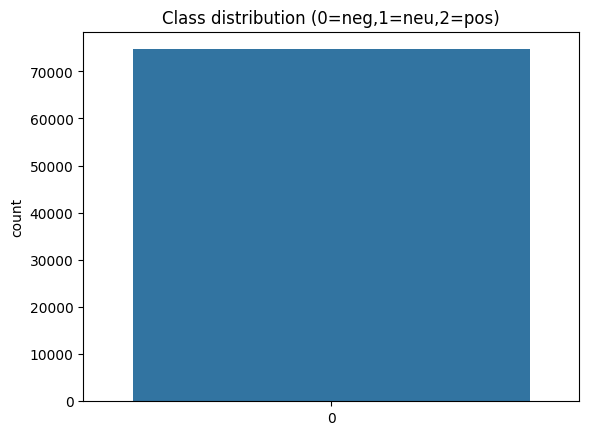

In [9]:
# نطبع القيم الفعلية لمشاهدة التسمية
print("Unique sentiment values:", df['sentiment'].unique())

# Normalize values to consistent case
df['sentiment'] = df['sentiment'].astype(str).str.strip().str.lower()

# mapping — عدّل إذا سماها dataset بطريقة مختلفة
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2,
    'irrelevant': 1  # إن وُجدت قيمة Irrelevant
}
# نتحقق من أي قيم غير مُعروفة
unknown = set(df['sentiment'].unique()) - set(label_map.keys())
print("Unknown sentiment labels:", unknown)

# نضيف عمود رقمي
df['label'] = df['sentiment'].map(label_map)
df = df.dropna(subset=['text_clean', 'label'])  # نتخلص من الصفوف التالفة
df['label'] = df['label'].astype(int)

# توزيع الفئات
print(df['label'].value_counts())
sns.countplot(df['label'])
plt.title("Class distribution (0=neg,1=neu,2=pos)")
plt.show()


In [10]:
X = df['text_clean'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 63479 Test: 11203


Training baseline model...
Accuracy: 0.8118361153262519
              precision    recall  f1-score   support

           0     0.8363    0.8081    0.8220      3382
           1     0.7844    0.8569    0.8191      4696
           2     0.8335    0.7482    0.7885      3125

    accuracy                         0.8118     11203
   macro avg     0.8181    0.8044    0.8098     11203
weighted avg     0.8138    0.8118    0.8114     11203



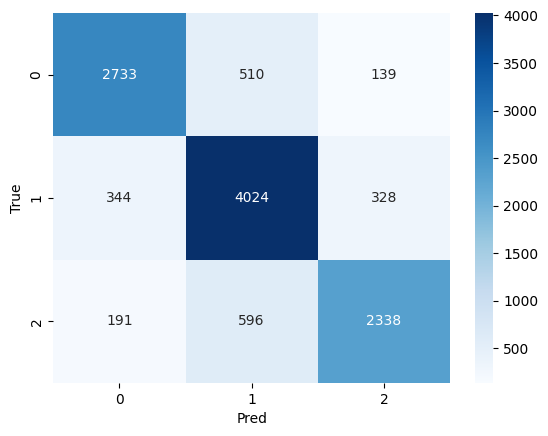

Saved baseline model to /kaggle/working/baseline_tfidf_logreg.joblib


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

print("Training baseline model...")
pipe.fit(X_train, y_train)

# تقييم
pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=4))

# confusion matrix
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

# حفظ النموذج والـ vectorizer (joblib)
joblib.dump(pipe, os.path.join(WORK_DIR, "baseline_tfidf_logreg.joblib"))
print("Saved baseline model to", os.path.join(WORK_DIR, "baseline_tfidf_logreg.joblib"))


In [12]:
# حفظ بعض الملفات المفيدة في working
report_path = os.path.join(WORK_DIR, "baseline_report.json")
with open(report_path, "w") as f:
    json.dump(classification_report(y_test, pred, output_dict=True), f, indent=2)

print("Files in working dir:")
!ls -la /kaggle/working


Files in working dir:
total 5444
drwxr-xr-x 3 root root    4096 Aug 11 11:48 .
drwxr-xr-x 5 root root    4096 Aug 11 11:38 ..
-rw-r--r-- 1 root root     750 Aug 11 11:48 baseline_report.json
-rw-r--r-- 1 root root 5556449 Aug 11 11:47 baseline_tfidf_logreg.joblib
drwxr-xr-x 2 root root    4096 Aug 11 11:38 .virtual_documents
